In [72]:
from unittest import TestCase
import yfinance as yf
import os
from matplotlib import pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import MACD
import numpy as np
import pandas
from ta.volatility import BollingerBands
import unittest

In [78]:
class Stock:
    def __init__(self, symbol):
        self.symbol = symbol
        self.technical_indicators = None
        self.prices = None


def buy_or_sell(buying, selling, df, strategy):
    last_signal = None
    indicators = []
    buy = []
    sell = []
    for i in range(0, len(df)):
        if buying(i, df) and last_signal != 'Buy':
            last_signal = 'Buy'
            indicators.append(last_signal)
            buy.append(df['Close'].iloc[i])
            sell.append(np.nan)
        
        elif selling(i, df)  and last_signal == 'Buy':
            last_signal = 'Sell'
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(df['Close'].iloc[i])
            
        else:
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(np.nan)

    df[f'{strategy}_Last_Signal'] = np.array(last_signal)
    df[f'{strategy}_Indicator'] = np.array(indicators)
    df[f'{strategy}_Buy'] = np.array(buy)
    df[f'{strategy}_Sell'] = np.array(sell)


def Tech(config, Stock):
    Stock.technical_indicators = pandas.DataFrame()
    Stock.technical_indicators['Close'] = Stock.prices
    Macd(config, Stock)
    RSI(config, Stock)
    bollinger_bands(config, Stock)


def Macd(config, Stock):
    window_slow = 26
    signal = 9
    window_fast = 12
    close_prices = Stock.prices
    df = Stock.technical_indicators
    macd = MACD(Stock.prices, window_slow, window_fast, signal)
    df['MACD'] = macd.macd()
    df['MACD_Histogram'] = macd.macd_diff()
    df['MACD_Signal'] = macd.macd_signal()
    buy_or_sell(
        lambda x, df: df['MACD'].values[x] < df['MACD_Signal'].iloc[x],
        lambda x, df: df['MACD'].values[x] > df['MACD_Signal'].iloc[x],df,'MACD')
    return df


def RSI(config, Stock):
    low_rsi = 40
    high_rsi = 70
    close_prices = Stock.prices
    df = Stock.technical_indicators
    rsi_time_period = 20
    rsi_indicator = RSIIndicator(close_prices, rsi_time_period)
    df['RSI'] = rsi_indicator.rsi()
    buy_or_sell(
        lambda x, df: df['RSI'].values[x] < low_rsi,
        lambda x, df: df['RSI'].values[x] > high_rsi,df, 'RSI')

    return df


def bollinger_bands(config, Stock):
    window = 20
    close_prices = Stock.prices
    df = Stock.technical_indicators
    indicator_bb = BollingerBands(close=close_prices, window=window, window_dev=2)
    df['Bollinger_Bands_Middle'] = indicator_bb.bollinger_mavg()
    df['Bollinger_Bands_Upper'] = indicator_bb.bollinger_hband()
    df['Bollinger_Bands_Lower'] = indicator_bb.bollinger_lband()
    buy_or_sell(
        lambda x, signal: signal['Close'].values[x] < signal['Bollinger_Bands_Lower'].values[x],
        lambda x, signal: signal['Close'].values[x] > signal['Bollinger_Bands_Upper'].values[x],
        df, 'Bollinger_Bands')

    return df


In [79]:
class Plotting:
    def plot(self, fig, Stock, data, strategy, axs):
        last_signal_val = data[f'{strategy}_Last_Signal'].values[-1]
        last_signal = 'Unknown' if not last_signal_val else last_signal_val
        title = f'Close Price Buy/Sell Signals using {strategy}.  Last Signal: {last_signal}'
        fig.suptitle(f'Top: {Stock.symbol} Stock Price. Bottom: {strategy}')

        if not data[f'{strategy}_Buy'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
        if not data[f'{strategy}_Sell'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
        axs[0].plot(Stock.prices, label='Close Price', color='blue', alpha=0.35)

        plt.xticks(rotation=45)
        axs[0].set_title(title)
        axs[0].set_xlabel('Date', fontsize=18)
        axs[0].set_ylabel('Close Price', fontsize=18)
        axs[0].legend(loc='upper left')
        axs[0].grid()

    def plot_macd(self, Stock):
        image = f'images/{Stock.symbol}_macd.png'
        macd = Stock.technical_indicators
        fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
        self.plot(fig, Stock, macd, 'MACD', axs)
        axs[1].plot(macd['MACD'], label=Stock.symbol+' MACD', color = 'green')
        axs[1].plot(macd['MACD_Signal'], label='Signal Line', color='orange')
        positive = macd['MACD_Histogram'][(macd['MACD_Histogram'] >= 0)]
        negative = macd['MACD_Histogram'][(macd['MACD_Histogram'] < 0)]
        axs[1].bar(positive.index, positive, color='green')
        axs[1].bar(negative.index, negative, color='red')
        axs[1].legend(loc='upper left')
        axs[1].grid()
        print(os.path.abspath(image))
        plt.show()

    def plot_rsi(self, Stock):
        low_rsi = 40
        high_rsi = 70
        image = f'images/{Stock.symbol}_rsi.png'
        rsi = Stock.technical_indicators
        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))
        self.plot(fig, Stock, rsi, 'RSI', axs)
        axs[1].fill_between(rsi.index, y1=low_rsi, y2=high_rsi, color='#adccff', alpha=0.3)
        axs[1].plot(rsi['RSI'], label='RSI', color='blue', alpha=0.35)
        axs[1].legend(loc='upper left')
        axs[1].grid()
        plt.show()

    def plot_bollinger_bands(self, Stock):
        image = f'images/{Stock.symbol}_bb.png'
        bollinger_bands = Stock.technical_indicators
        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))
        self.plot(fig, Stock, bollinger_bands, 'Bollinger_Bands', axs)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Middle'], label='Middle', color='blue', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Upper'], label='Upper', color='green', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Lower'], label='Lower', color='red', alpha=0.35)
        axs[1].fill_between(bollinger_bands.index, bollinger_bands['Bollinger_Bands_Lower'], bollinger_bands['Bollinger_Bands_Upper'], alpha=0.1)
        axs[1].legend(loc='upper left')
        axs[1].grid()
        plt.show()


C:\Users\aman\images\BTC_macd.png


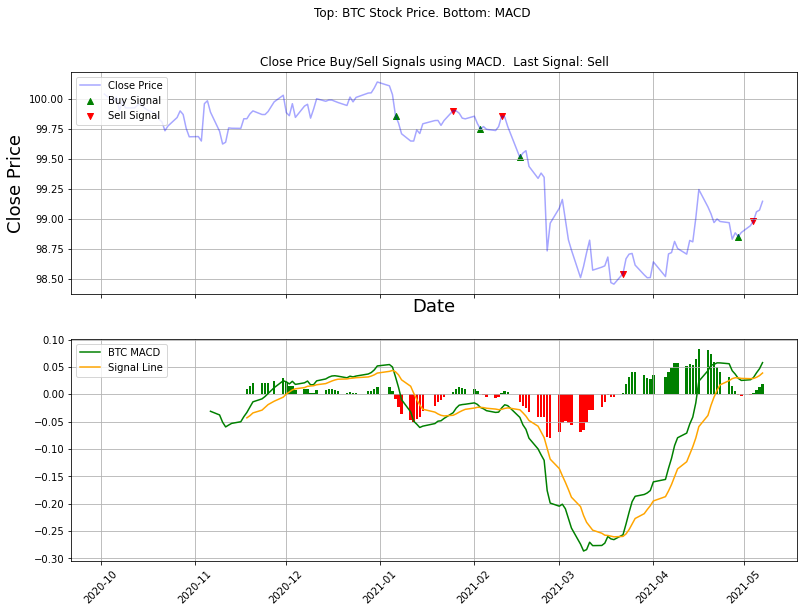

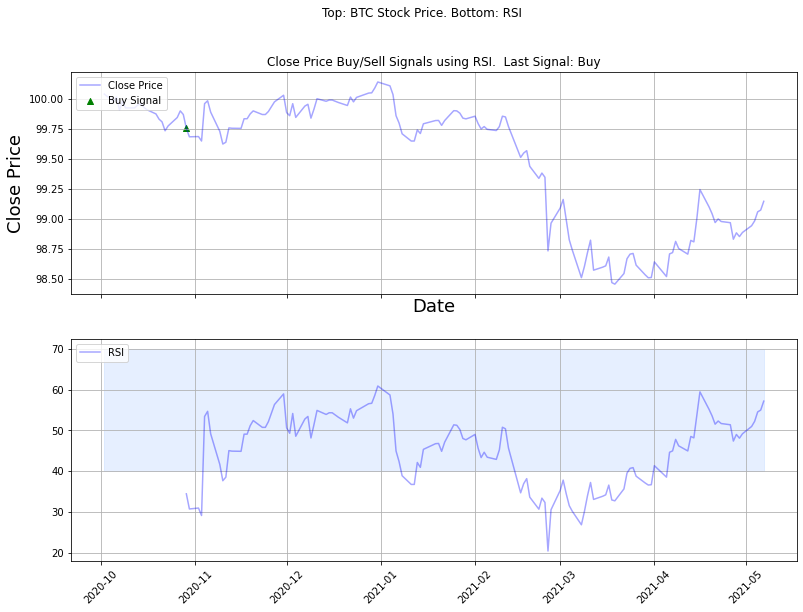

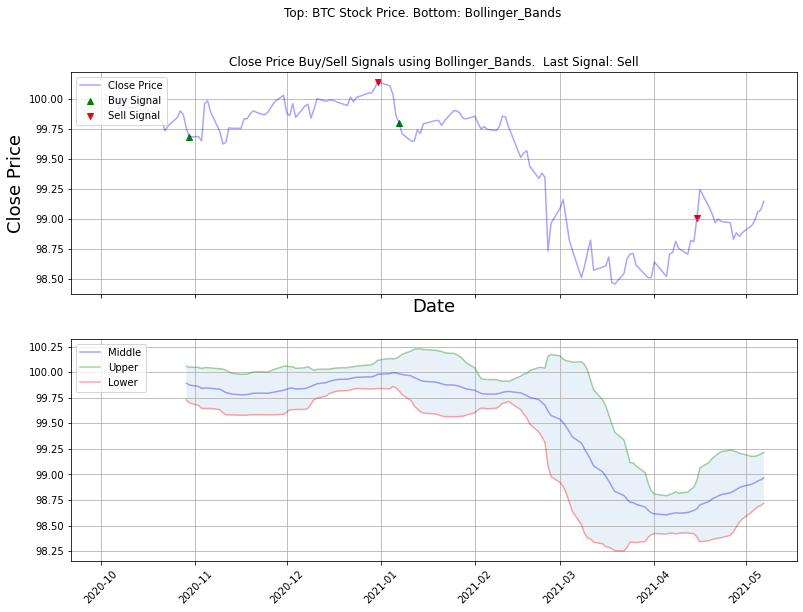

.
----------------------------------------------------------------------
Ran 1 test in 1.354s

OK


In [81]:
class TestTechnicalIndicator(TestCase):

    def test_tech_indicator(self):
        stock_watch = Stock("BTC")
        config = {}
        
        stock_watch.prices = yf.Ticker(stock_watch.symbol).history(period="5y")["Close"]
        
        Tech(config, stock_watch)

        mod = Plotting()
        mod.plot_macd(stock_watch)
        mod.plot_rsi(stock_watch)
        mod.plot_bollinger_bands(stock_watch)
        
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)        